In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
import pandas as pd
labels_csv = pd.read_csv("/content/drive/MyDrive/TerrainPrediction/TerrainDataset - Sheet1.csv")
labels_csv.head()

,id,road_type
0,0,Pothole
1,1,Pothole
2,2,Pothole
3,3,Pothole
4,4,Pothole


In [ ]:
labels_csv.describe()

,id
count,823.000000
mean,411.006075
std,237.734407
min,0.000000
25%,205.500000
50%,411.000000
75%,616.500000
max,823.000000


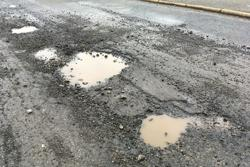

In [ ]:
# Let's view one image
from IPython.display import Image
Image(filename= "/content/drive/MyDrive/TerrainPrediction/images/0.jpg")

In [ ]:
# Create path name's for image ids
filenames: list = [f"/content/drive/MyDrive/TerrainPrediction/images/{id}.jpg" for id in labels_csv.id]

filenames[:10]

['/content/drive/MyDrive/TerrainPrediction/images/0.jpg',
 '/content/drive/MyDrive/TerrainPrediction/images/1.jpg',
 '/content/drive/MyDrive/TerrainPrediction/images/2.jpg',
 '/content/drive/MyDrive/TerrainPrediction/images/3.jpg',
 '/content/drive/MyDrive/TerrainPrediction/images/4.jpg',
 '/content/drive/MyDrive/TerrainPrediction/images/5.jpg',
 '/content/drive/MyDrive/TerrainPrediction/images/6.jpg',
 '/content/drive/MyDrive/TerrainPrediction/images/7.jpg',
 '/content/drive/MyDrive/TerrainPrediction/images/8.jpg',
 '/content/drive/MyDrive/TerrainPrediction/images/9.jpg']

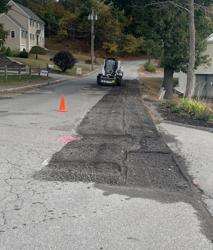

In [ ]:
# verify path is correct
Image(data= filenames[10])

In [ ]:
# preparing labels
labels = labels_csv.road_type.to_numpy()
labels[:5]

array(['Pothole', 'Pothole', 'Pothole', 'Pothole', 'Pothole'],
      dtype=object)

In [ ]:
import numpy as np
unique_roads = np.unique(ar= labels)

len(unique_roads)

3

In [ ]:
# Turning image label to boolean array
boolean_labels = [label == unique_roads for label in labels]
boolean_labels[:1]

[array([False, False,  True])]

In [ ]:
# Creating train and validation sets
X = filenames
y = boolean_labels

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size= 0.2)

len(X_train) == len(y_train) and len(X_val) == len(y_val)

True

In [ ]:
X_train[:1], y_train[:1]

(['/content/drive/MyDrive/TerrainPrediction/images/779.jpg'],
 [array([ True, False, False])])

In [ ]:
X_val[:1], y_val[:1]

(['/content/drive/MyDrive/TerrainPrediction/images/445.jpg'],
 [array([False,  True, False])])

## Convering image into tensors

In [ ]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(img_path: str, img_size: int = IMG_SIZE) -> tf.Tensor:
    """ # DocString
    Takes an image file path and turns into a Tensor.
    """
    # Read in an image file
    image = tf.io.read_file(filename= img_path)

    # Turn the jpeg image into numerical Tensor with 3 color channel (Red, Green, Blue)
    image = tf.image.decode_jpeg(contents= image, channels= 3) # content = image as we read the image path above

    # convert the color channel values from 0 - 255 to 0 - 1 values / normalization
    image = tf.image.convert_image_dtype(image= image, dtype= tf.float32) # Convert image to dtype, scaling its values if needed.
    # dtype= tf.float32 or image = image / 255.0 both are same

    # Resize the image to our desired value (224, 224)
    image = tf.image.resize(images= image, size= (img_size, img_size))

    return image

In [ ]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
    """ # DocString
    Takes an image file path name and the assosciated label,
    processes the image and returns a tuple of (image, label).
    """
    image = process_image(img_path= image_path)
    return image, label # By default it returns as tuple like (image, label)

In [ ]:
# Define batch size, 32 is a good start
BATCH_SIZE: int = 32 # constant

# Create a function to turn data into batches
                         # for test set
def create_data_batches(X, y= None, batch_size: int= BATCH_SIZE, valid_data: bool= False, test_data: bool= False):
    """ # DcoString
    Creates batches of data out of image (X) and label (y) pairs.
    Shuffles the data if it's training data but doesn't shuffle if it's validation data.
    Also accepts test data as input (no labels).
    """
    # If the data is test dataset, we probably don't have labels
    if test_data:
        print('Creating test data batches...') # for conifirmation

        # Turn filepaths and labels into Tensors
        # tf.data.Dataset - is how to create dataset in tf, from_tensor_slices - Creates a Dataset whose elements are slices of the given tensors.
        data = tf.data.Dataset.from_tensor_slices(tf.constant(X)) # convert X to tensor by tf.constant, and only filepaths (no labels)
        # Transforming
        # map - Maps map_func across the elements of this dataset.
        data_batch = data.map(map_func= process_image).batch(batch_size= BATCH_SIZE) # batch(n) splits elements into n size set
        return data_batch           # process_image() function we created above

    # If the data in valid dataset, we don't need to shuffle it
    elif valid_data:
        print('Creating valid data batches...')

        # Turn filepaths and labels into Tensors
        # Don't forget to covert to tensor by tf.constant
        data = tf.data.Dataset.from_tensor_slices( (tf.constant(X), # filepaths
                                                    tf.constant(y)) ) # labels
        # transforming
        data_batch = data.map(map_func= get_image_label).batch(batch_size= BATCH_SIZE)
        return data_batch             # get_image_label() fuction we created above

    # For training dataset, we have to shuffle it to learn more pattern
    else:
        print('Creating training data batches...')

        # Turn filepaths and labels into Tensors
        data = tf.data.Dataset.from_tensor_slices( (tf.constant(X), # filepaths
                                                    tf.constant(y)) ) # labels

        # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
        data = data.shuffle(buffer_size= len(X)) # shuffles buffer_size elements in dataset, So 100% shuffled

        # Create (image, label) tuples (this also turns image path into a preprocessed image)
        data = data.map(map_func= get_image_label)

        # Turn the training data into batches
        data_batch = data.batch(batch_size= BATCH_SIZE)
        return data_batch


In [ ]:
# Creating train and test data batches
train_data = create_data_batches(X= X_train, y= y_train)
val_data = create_data_batches(X= X_val, y= y_val, valid_data= True)

Creating training data batches...
Creating valid data batches...


In [ ]:
# Visuallising train and validation
import matplotlib.pyplot as plt

# Create a function to viewing images on dataset
def show_10_images(images, labels): # We gonna pass batches, So it'll contain 32 images and labels
    """ # DocString
    Displays a plot of 10 images and their labels from a data batch.
    """
    # Setup a figure
    plt.figure(figsize= (10, 10)) # Create a new figure.
    # Loop through 10 (for displaying 10 images)
    for i in range(10):
        # Create subplots (5 rows, 5 columns)
                   # nrows,ncols, index  # i + 1 As i starts from 0 , plt.subplot() doesnt support keyword argument
        ax = plt.subplot(2, 5, i+1) # Add a subplot to the current figure.
        # Display an image
        plt.imshow(X= images[i]) # from 32 it'll display first 10
        # Add the image label as title
        plt.title(label= unique_roads[labels[i].argmax()]) # As our y(label) is boolean roads and argmax() returns the index where 1 is found
        # Turn the grid lines off
        plt.axis('off')

In [ ]:
train_images, train_labels = next(train_data.as_numpy_iterator())
# as_numpy_iterator - Returns an iterator which converts all elements of the dataset to numpy.

train_images, train_labels # It's a single batch so it contains 32 images and labels

(array([[[[1.72549024e-01, 1.76470593e-01, 1.56862751e-01],
          [1.72549024e-01, 1.76470593e-01, 1.56862751e-01],
          [1.72549024e-01, 1.76470593e-01, 1.56862751e-01],
          ...,
          [1.05882362e-01, 1.01960793e-01, 8.23529437e-02],
          [1.12359986e-01, 1.08438417e-01, 8.88305679e-02],
          [1.13725498e-01, 1.09803930e-01, 9.01960805e-02]],
 
         [[1.75525218e-01, 1.79446787e-01, 1.59838945e-01],
          [1.75007045e-01, 1.78928614e-01, 1.59320772e-01],
          [1.72549024e-01, 1.76470593e-01, 1.56862751e-01],
          ...,
          [1.08858548e-01, 1.04936980e-01, 8.53291303e-02],
          [1.15336172e-01, 1.11414604e-01, 9.18067619e-02],
          [1.16701685e-01, 1.12780116e-01, 9.31722745e-02]],
 
         [[1.78680390e-01, 1.82601959e-01, 1.62994117e-01],
          [1.76196262e-01, 1.80117831e-01, 1.60509989e-01],
          [1.74894959e-01, 1.78816527e-01, 1.59208685e-01],
          ...,
          [1.12149872e-01, 1.08228303e-01, 8.8620

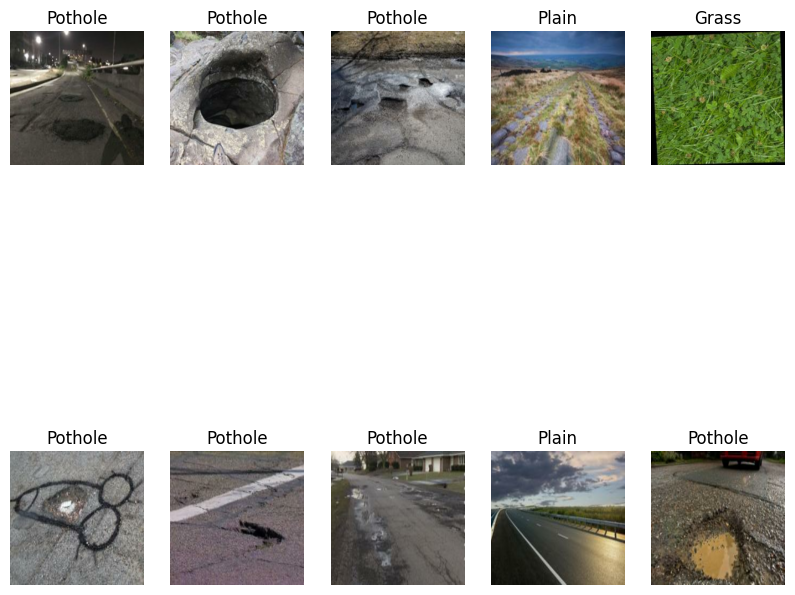

In [ ]:
show_10_images(images= train_images, labels= train_labels)

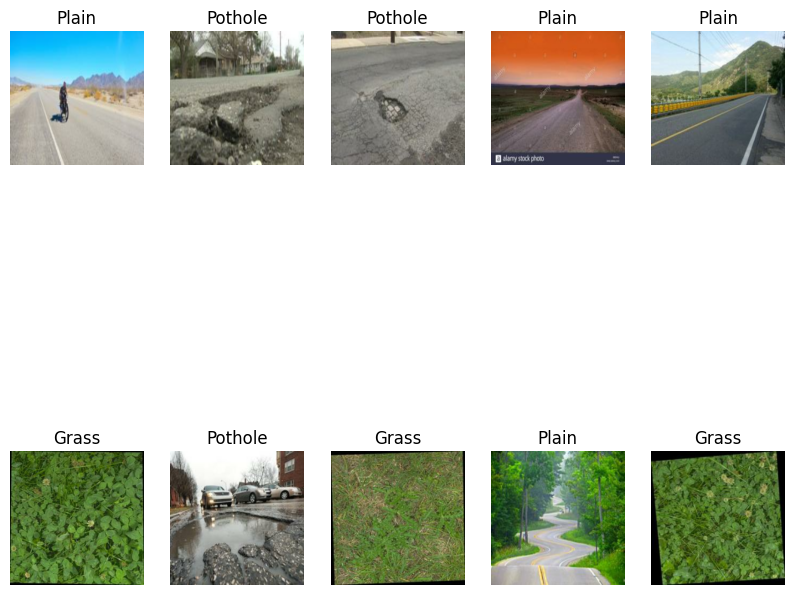

In [ ]:
# Now let's visuallize our validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
# as_numpy_iterator - Returns an iterator which converts all elements of the dataset to numpy.
show_10_images(images= val_images, labels= val_labels)

In [ ]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color channel

# Setup output shape to the model
OUTPUT_SHAPE = len(unique_roads)

# Setup model URL from TensorFlow Hub - using pre-built model to save our time from building it from scratch
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

In [ ]:
# Create a function which builds keras model
def create_model(input_shape= INPUT_SHAPE, output_shape= OUTPUT_SHAPE, model_url= MODEL_URL):
    """ # DocString
    Builds a keras model with layers and returns it.
    """
    print("building model with...", model_url)

    # classes are PascalCase

    # Setup the model layers, Insatancing the model
    model = tf.keras.Sequential([ # groups a linear stack of layers into a tf.keras.Model.
        hub.KerasLayer(model_url), # Layer 1 (input layer)
        tf.keras.layers.Dense(units= output_shape, # Dense - Just your regular densely-connected NN(neural network) layer.
                              activation= "softmax") # Layer 2 (output layer)
    ])                      # the activation differs for kind of problem you are working it

    # compile the model, putting the model together
    model.compile( # Configures the model for training.
        loss = tf.keras.losses.CategoricalCrossentropy(), # Computes the crossentropy loss between the labels and predictions
        optimizer = tf.keras.optimizers.Adam(), # Optimizer that implements the Adam algorithm.
        metrics = ["accuracy"]      # Adam optimizer - It is efficient to use and consumes very little memory
    )

    # Build a model
    model.build(input_shape= input_shape) # Builds the model based on input shapes received.

    return model

In [ ]:
model = create_model()
model.summary() # Prints a string summary of the network.

building model with... https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 3)                 3006      
                                                                 
Total params: 5435719 (20.74 MB)
Trainable params: 3006 (11.74 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


In [ ]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
import datetime
import os

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
    # Create a log directory in dog breed for storing logs
    logdir = os.path.join( # Join two or more pathname components
        '/content/drive/MyDrive/TerrainPrediction/logs', # the folder we created path
        # Make it so the logs get tracked whenever we run an experiment
        datetime.datetime.now().strftime("%Y%m%d-%H%M%S") # Format
    )
                                    # log_dir is where it stores parsed log files
    return tf.keras.callbacks.TensorBoard(log_dir= logdir) # TensorBoard is a visualization tool provided with TensorFlow.

In [ ]:
# Stop training when a monitored metric has stopped improving.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor= "val_accuracy",
                                                  patience= 3) # after 3 epochs with no improvement it stops training the model

In [ ]:
# Epochs is giving chances for model to figure out the patterns
NUM_EPOCHS = 20 #@param {type: "slider", min: 10, max: 100, step: 10}

In [ ]:
# Build a function to train and return a trained model
def train_model():
    """ # DocString
    Trains a given model and returns a trained model.
    """
    # Create a model
    model = create_model()

    # Create new TensorBoard session everytime we train a model
    tensorboard = create_tensorboard_callback() # Stores in logs

    # Fit the model to the data, passing it the callbacks we created
    model.fit( # Trains the model for a fixed number of epochs (iterations on a dataset).
        x= train_data,
        epochs= NUM_EPOCHS,
        validation_data= val_data,
        validation_freq= 1, # How many intervals to check the validation data
        callbacks= [tensorboard, early_stopping]
    )

    # Return the fitted model
    return model

In [ ]:
model = train_model()

building model with... https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Epoch 1/20
21/21 [==============================] - 298s 13s/step - loss: 0.7534 - accuracy: 0.7128 - val_loss: 0.1442 - val_accuracy: 0.9455
Epoch 2/20
21/21 [==============================] - 2s 75ms/step - loss: 0.0995 - accuracy: 0.9620 - val_loss: 0.0875 - val_accuracy: 0.9636
Epoch 3/20
21/21 [==============================] - 2s 80ms/step - loss: 0.0700 - accuracy: 0.9772 - val_loss: 0.0652 - val_accuracy: 0.9636
Epoch 4/20
21/21 [==============================] - 2s 73ms/step - loss: 0.0558 - accuracy: 0.9833 - val_loss: 0.0633 - val_accuracy: 0.9636
Epoch 5/20
21/21 [==============================] - 2s 72ms/step - loss: 0.0469 - accuracy: 0.9878 - val_loss: 0.0510 - val_accuracy: 0.9758
Epoch 6/20
21/21 [==============================] - 2s 92ms/step - loss: 0.0399 - accuracy: 0.9924 - val_loss: 0.0523 - val_accuracy: 0.9697
Epoch 7/20
21/21 [==============================] - 2s 97m

In [ ]:
# Make predictions on validation data (not used to train on)
predictions = model.predict(x= val_data, verbose= 1) # Generates output predictions for the input samples.
predictions

6/6 [==============================] - 1s 59ms/step


array([[2.41773523e-06, 9.99198139e-01, 7.99536065e-04],
       [3.34805009e-06, 1.15710648e-03, 9.98839557e-01],
       [5.70582279e-06, 2.45223113e-04, 9.99749124e-01],
       [3.63812171e-04, 9.69372809e-01, 3.02634183e-02],
       [1.60764841e-06, 9.99980211e-01, 1.81874548e-05],
       [9.98839557e-01, 7.40427000e-04, 4.20086755e-04],
       [1.45983722e-06, 3.15419020e-04, 9.99683142e-01],
       [9.99285877e-01, 6.30395196e-04, 8.37114276e-05],
       [4.29101819e-05, 9.97797370e-01, 2.15972238e-03],
       [9.76313412e-01, 2.36606430e-02, 2.59979406e-05],
       [6.42918108e-04, 7.68151462e-01, 2.31205598e-01],
       [9.96728897e-01, 4.22897894e-04, 2.84820073e-03],
       [1.60183589e-07, 9.99909163e-01, 9.07339199e-05],
       [1.61489083e-07, 9.99927521e-01, 7.23368503e-05],
       [1.01901901e-06, 9.99997854e-01, 1.09837060e-06],
       [4.43049839e-06, 3.14745046e-02, 9.68521059e-01],
       [2.16972808e-06, 9.95537400e-01, 4.46048053e-03],
       [5.21776968e-08, 9.99955

In [ ]:
# Turn prediction probabilities into thier respective label (easier to understand)
def get_pred_label(prediction_probabilities):
    """ # DocString
    Turns an array of prediction probabilities into a label
    """
    return unique_roads[np.argmax(prediction_probabilities)]

In [ ]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
    """ $ DocString
    Takes a batched dataset of (image, label) Tensors and reutrns separate arrays
    of images and labels.
    """
    images = []
    labels = []

    # Loop through unbatched data
                            # unbatches the batched data
    for image, label in data.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(unique_breeds[np.argmax(label)])

    return images, labels

### Saving model

In [ ]:
# Create a function to save a model
def save_model(model, suffix= None):
    """ # DocString
    Saves a given model in a models directory and appends a suffix (string).
    """
    model_dir = os.path.join("/content/drive/MyDrive/TerrainPrediction/Trained models",
                             datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))

    model_path = model_dir + "-" + suffix + ".h5" # save format of a model
    print(f"Saving model to {model_path}")
    model.save(filepath= model_path) # Saves the model to Tensorflow SavedModel or a single HDF5 file
    return model_path # to use it in loading a model

In [ ]:
# Save our model trained on 1000 images
save_model(model= model, suffix= "Terrain-Road-prediction-model-mobilenetv2-Adam") # To remind ourselves what we used

Saving model to /content/drive/MyDrive/TerrainPrediction/Trained models/20231209-07371702107447-Terrain-Road-prediction-model-mobilenetv2-Adam.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'/content/drive/MyDrive/TerrainPrediction/Trained models/20231209-07371702107447-Terrain-Road-prediction-model-mobilenetv2-Adam.h5'